In [2]:
# !git clone https://github.com/dmc27/missing_pixels.git

In [1]:
import cv2 as cv
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.metrics import accuracy_score

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR


from utils.utils import *
from utils.database import MissingPixelDataset
from model.architecture import *


import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)



BLOCK_SIZE = 8
BATCH_SIZE = 512
NUM_EPOCHS = 50
LEARNING_RATE = 1e-5
# WEIGHT_DECAY = 0.05
STEPLR_GAMMA = 0.1
RUN_UTILITY = False
USE_PRETRAINED = False

IMG_PATH = './dataset/original_image/'
IMG_TRAINING_PATH = './dataset/training_image/train/'
IMG_SAVE_PATH = './dataset/missing_pixel/'

In [2]:
if RUN_UTILITY:
    create_dataset_autoencoder(IMG_PATH, IMG_SAVE_PATH, BLOCK_SIZE, img_size=(256, 256))

In [3]:
# Calling PrepareDataset class in the utilities for preparing the dataset for training,
# X is the input to the network architecture, and y is the target output of the network
data = PrepareDataset(IMG_TRAINING_PATH, IMG_SAVE_PATH, block_size=BLOCK_SIZE)
X, y = data.create_dataset_original(sample_size = 10000)


# Creating dataset for the pytorch model (converted to tensor)
train_dataset = MissingPixelDataset(X, y, scaling=False)


# Create training dataloader to make a batch learning for the pytorch model
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

100%|██████████| 10000/10000 [00:09<00:00, 1087.11it/s]


In [4]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
torch.cuda.device_count()

2

In [6]:
model = OriginalModel().double().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
# scheduler = StepLR(optimizer, step_size=50, gamma=STEPLR_GAMMA, verbose=True)

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (X_train, y_train) in enumerate(pbar):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        output = model(X_train)
        
        loss = criterion(output, y_train)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        pbar.set_description(desc= f'Epoch {epoch} loss={loss.item()} batch_id={batch_idx}')
    
    train_loss /= len(train_loader.dataset)

    print('Train set: Average loss: {:.32f}'.format(train_loss))

In [8]:
if USE_PRETRAINED:
    model.load_state_dict(torch.load('./trained_model/convmodel_30k_0.pth'))

In [9]:
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, device, train_dataloader, optimizer, criterion, epoch)
    # plot_loss()
    # test(model, device, test_dataloader, criterion)
    # scheduler.step()

Epoch 1 loss=0.0023778597018026437 batch_id=19999: 100%|██████████| 20000/20000 [01:25<00:00, 234.32it/s]


Train set: Average loss: 0.00002359869711614274878793383328


Epoch 2 loss=0.003179702719389035 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.32it/s] 


Train set: Average loss: 0.00000478441437542960117470808995


Epoch 3 loss=0.0024411555090337674 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.49it/s]


Train set: Average loss: 0.00000463090078129551218944241417


Epoch 4 loss=0.0021625675623124377 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.47it/s]


Train set: Average loss: 0.00000454398091254568089412393603


Epoch 5 loss=0.002623415047081055 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.47it/s] 


Train set: Average loss: 0.00000447842222651473612288815923


Epoch 6 loss=0.0015809792409028655 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.22it/s]


Train set: Average loss: 0.00000442321862932026652688762003


Epoch 7 loss=0.0016702966701796183 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.17it/s]


Train set: Average loss: 0.00000437414406966021798597952369


Epoch 8 loss=0.002326378463515565 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.54it/s] 


Train set: Average loss: 0.00000432964143736121326446831051


Epoch 9 loss=0.0018910783594921297 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.69it/s]


Train set: Average loss: 0.00000428879738098417324085927932


Epoch 10 loss=0.0026341054622987664 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 278.85it/s]


Train set: Average loss: 0.00000425048842474683376035969953


Epoch 11 loss=0.0026463151822080835 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 279.25it/s]


Train set: Average loss: 0.00000421551557299071077446455530


Epoch 12 loss=0.00229539337260844 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 278.66it/s]  


Train set: Average loss: 0.00000418260768915945207709408682


Epoch 13 loss=0.002337547882425381 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.77it/s] 


Train set: Average loss: 0.00000415206150781867157567930904


Epoch 14 loss=0.0019358042237331576 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 278.09it/s]


Train set: Average loss: 0.00000412301841248911794465814573


Epoch 15 loss=0.0017491576689959445 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 280.45it/s]


Train set: Average loss: 0.00000409533508125868903033224219


Epoch 16 loss=0.001461058400985881 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 279.59it/s] 


Train set: Average loss: 0.00000406856627678270201876106066


Epoch 17 loss=0.0025079873684706426 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.49it/s]


Train set: Average loss: 0.00000404257814380790517948737958


Epoch 18 loss=0.0019577168961257187 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.64it/s]


Train set: Average loss: 0.00000401719393801970461286036593


Epoch 19 loss=0.0022030878421710337 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.02it/s]


Train set: Average loss: 0.00000399185822857760737379477500


Epoch 20 loss=0.0022936175771575296 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 274.94it/s]


Train set: Average loss: 0.00000396803006467083628738519788


Epoch 21 loss=0.001998073205537883 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.48it/s] 


Train set: Average loss: 0.00000394621506029323730927686059


Epoch 22 loss=0.0019397877479025297 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 278.41it/s]


Train set: Average loss: 0.00000392578525910365879126239994


Epoch 23 loss=0.0017381559327206326 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 279.73it/s]


Train set: Average loss: 0.00000390636951587450227197165220


Epoch 24 loss=0.0016413784282290204 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 279.39it/s]


Train set: Average loss: 0.00000388599046801431176789871913


Epoch 25 loss=0.0017844163761489128 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.28it/s]


Train set: Average loss: 0.00000386470192654249752639604790


Epoch 26 loss=0.0019389091822902811 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 277.96it/s]


Train set: Average loss: 0.00000384394085010084891543139310


Epoch 27 loss=0.002981690945281719 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 277.83it/s] 


Train set: Average loss: 0.00000382425420700406699882258760


Epoch 28 loss=0.0013670114021711332 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.79it/s]


Train set: Average loss: 0.00000380572531307168997411274902


Epoch 29 loss=0.0015210216618334253 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.80it/s]


Train set: Average loss: 0.00000378854148673250239903222136


Epoch 30 loss=0.001926076364748237 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.18it/s] 


Train set: Average loss: 0.00000377222074884886460210964287


Epoch 31 loss=0.0031801336061109647 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.61it/s]


Train set: Average loss: 0.00000375669001038176615474544623


Epoch 32 loss=0.0018211924693040545 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 274.63it/s]


Train set: Average loss: 0.00000374175921048311239724753693


Epoch 33 loss=0.0018171414159220578 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.73it/s]


Train set: Average loss: 0.00000372796897495745388956050678


Epoch 34 loss=0.002166330397499394 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.65it/s] 


Train set: Average loss: 0.00000371447165571108877424083734


Epoch 35 loss=0.0015823555816005443 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.70it/s]


Train set: Average loss: 0.00000370135183487068911747366537


Epoch 36 loss=0.0020850223721152056 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 277.44it/s]


Train set: Average loss: 0.00000368873756546983873658802563


Epoch 37 loss=0.0015812986596286823 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.99it/s]


Train set: Average loss: 0.00000367652386981759807721209174


Epoch 38 loss=0.0023832253799716298 batch_id=19999: 100%|██████████| 20000/20000 [01:11<00:00, 277.98it/s]


Train set: Average loss: 0.00000366482262912993048419073652


Epoch 39 loss=0.002068078751320232 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.20it/s] 


Train set: Average loss: 0.00000365341869937630137415919725


Epoch 40 loss=0.0019063747138204578 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 274.08it/s]


Train set: Average loss: 0.00000364243511139443830636132533


Epoch 41 loss=0.0011355873157612437 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 274.58it/s]


Train set: Average loss: 0.00000363194466634470253393277700


Epoch 42 loss=0.0017286797161909983 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 274.95it/s]


Train set: Average loss: 0.00000362167378080433799143571238


Epoch 43 loss=0.0016915244115811524 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.73it/s]


Train set: Average loss: 0.00000361223235550767392162659422


Epoch 44 loss=0.0015426770448014723 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.66it/s]


Train set: Average loss: 0.00000360318996668758989625419922


Epoch 45 loss=0.0014971977646267578 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.10it/s]


Train set: Average loss: 0.00000359432356175655359016747614


Epoch 46 loss=0.0019245475107305587 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.31it/s]


Train set: Average loss: 0.00000358588683899528716704377743


Epoch 47 loss=0.0017373608538837847 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 276.43it/s]


Train set: Average loss: 0.00000357744729726207346071163024


Epoch 48 loss=0.0017056954816056906 batch_id=19999: 100%|██████████| 20000/20000 [01:12<00:00, 275.77it/s]


Train set: Average loss: 0.00000356954816105257150744855567


Epoch 49 loss=0.001915491925748354 batch_id=19999: 100%|██████████| 20000/20000 [01:18<00:00, 253.36it/s] 


Train set: Average loss: 0.00000356171489648430417767027527


Epoch 50 loss=0.001961686762649085 batch_id=19999: 100%|██████████| 20000/20000 [01:10<00:00, 282.28it/s] 

Train set: Average loss: 0.00000355426590441293701949166187


In [10]:
torch.save(model.state_dict(), 'trained_model/original_trainsize_10k_batch_512.pth')

In [11]:
test_image_name = 'balloon.bmp'

In [12]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + test_image_name)
tiled_image = data._reshape_split(image)
X = tiled_image.copy()
X[:, 3:5, 3:5] = np.array([[None, None],
                            [None, None]])
test = X[~np.isnan(X)].reshape(-1, 60) / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X[:, 3:5, 3:5] = prediction_result
pred = X.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
# a = model(torch.tensor(X[:1024], dtype=torch.float32).to(device)).detach().cpu().numpy()

In [11]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + test_image_name)
tiled_image = data._reshape_split(image)
X = tiled_image.copy()
X[:, 3:5, 3:5] = np.array([[0., 0.],
                            [0., 0.]])
test = X / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X[:, 3:5, 3:5] = prediction_result
X = X.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)

In [17]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + test_image_name)
missing_pixel_image = data._create_missing_pixel_img(image)
tiled_image = data._reshape_split(missing_pixel_image)
test = tiled_image / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
# prediction_result.shape
pred = prediction_result.reshape(8, 8, 32, 32).swapaxes(1, 2).reshape(256, 256) * 255.

MSE = 9.21


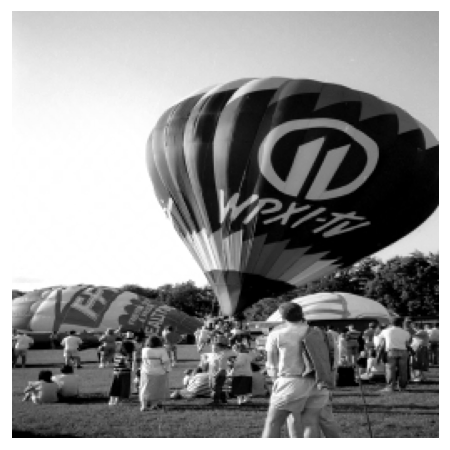

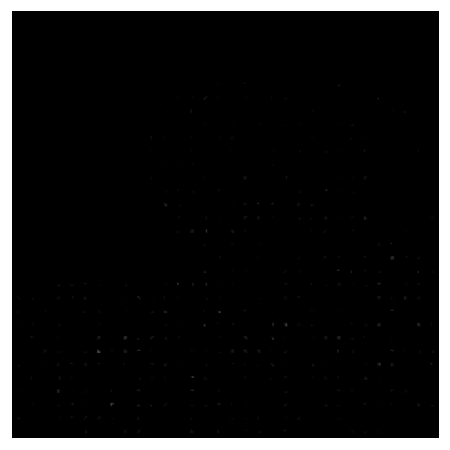

In [13]:
img = cv.imread(join(IMG_PATH, test_image_name), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

# compute the MSE between the original and reconstructed images
err = pred - img
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(pred, "gray", dpi=72)
imshow(pred - img, 'gray', dpi = 72)
